# Neural Networks

Neural networks being a very powerful class of models, especially in cases where the learning of representations from low-level information (such as pixels, audio samples or text) is key, sensAI provides many useful abstractions for dealing with this class of models, facilitating data handling, learning and evaluation.

sensAI mainly provides abstractions for PyTorch, but there is also rudimentary support for TensorFlow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import sys; sys.path.extend(["../src", ".."])
import sensai
import pandas as pd
import numpy as np
from typing import *
import config
import warnings
import functools

cfg = config.get_config()
warnings.filterwarnings("ignore")
sensai.util.logging.configure()

## Image Classification

As an example use case, let us solve the classification problem of classifying digits in pixel images from the MNIST dataset. Images are greyscale (no colour information) and 28x28 pixels in size.

In [3]:
mnist_df = pd.read_csv(cfg.datafile_path("mnist_train.csv.zip"))

The data frame contains one column for every pixel, each pixel being represented by an 8-bit integer (0 to 255).

In [4]:
mnist_df.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's create the I/O data for our experiments.

In [5]:
mnistIoData = sensai.InputOutputData.from_data_frame(mnist_df, "label")

Now that we have the image data separated from the labels, let's write a function to restore the 2D image arrays and take a look at some of the images.

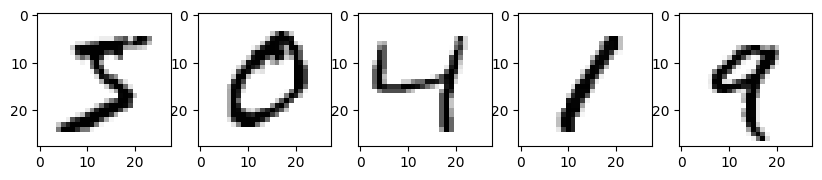

In [6]:
import matplotlib.pyplot as plt

def reshape_2d_image(series):
    return series.values.reshape(28, 28)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
for i in range(5):
    axs[i].imshow(reshape_2d_image(mnistIoData.inputs.iloc[i]), cmap="binary")

### Applying Predefined Models



We create an evaluator in order to test the performance of our models, randomly splitting the data.

In [7]:
evaluator_params = sensai.evaluation.ClassificationEvaluatorParams(fractional_split_test_fraction=0.2)
eval_util = sensai.evaluation.ClassificationModelEvaluation(mnistIoData, evaluator_params=evaluator_params)

One pre-defined model we could try is a simple multi-layer perceptron. A PyTorch-based implementation is provided via class `MultiLayerPerceptronVectorClassificationModel`. This implementation supports CUDA-accelerated computations (on Nvidia GPUs), yet we shall stick to CPU-based computation (cuda=False) in this tutorial.

In [8]:
import sensai.torch

nn_optimiser_params = sensai.torch.NNOptimiserParams(early_stopping_epochs=2, batch_size=54)
torch_mlp_model = sensai.torch.models.MultiLayerPerceptronVectorClassificationModel(hidden_dims=(50, 20),
        cuda=False, normalisation_mode=sensai.torch.NormalisationMode.MAX_ALL,
        nn_optimiser_params=nn_optimiser_params, p_dropout=0.0) \
    .with_name("MLP")

Neural networks work best on **normalised inputs**, so we have opted to apply basic normalisation by specifying a normalisation mode which will transforms inputs by dividing by the maximum value found across all columns in the training data. For more elaborate normalisation options, we could have used a data frame transformer (DFT), particularly `DFTNormalisation` or `DFTSkLearnTransformer`.

sensAI's default **neural network training algorithm** is based on early stopping, which involves checking, in regular intervals, the performance of the model on a validation set (which is split from the training set) and ultimately selecting the model that performed best on the validation set. You have full control over the loss evaluation method used to select the best model (by passing a respective `NNLossEvaluator` instance to NNOptimiserParams) as well as the method that is used to split the training set into the actual training set and the validation set (by adding a `DataFrameSplitter` to the model or using a custom `TorchDataSetProvider`).

Given the vectorised nature of our MNIST dataset, we can apply any type of model which can accept the numeric inputs. Let's compare the neural network we defined above against another pre-defined model, which is based on a scikit-learn implementation and uses decision trees rather than neural networks.

In [9]:
random_forest_model = sensai.sklearn.classification.SkLearnRandomForestVectorClassificationModel(
        min_samples_leaf=1,
        n_estimators=10) \
    .with_name("RandomForest")

Let's compare the two models using our evaluation utility.

In [10]:
eval_util.compare_models([random_forest_model, torch_mlp_model]);

Both models perform reasonably well.

### Creating a Custom CNN Model

Given that this is an image recognition problem, it can be sensible to apply convolutional neural networks (CNNs), which can analyse patches of the image in order to generate more high-level features from them.
Specifically, we shall apply a neural network model which uses multiple convolutions, a max-pooling layer and a multi-layer perceptron at the end in order to produce the classification.

For classification and regression, sensAI provides the fundamental classes `TorchVectorClassificationModel` and `TorchVectorRegressionModel` respectively. Ultimately, these classes will wrap an instance of `torch.nn.Module`, the base class for neural networks in PyTorch.

#### Wrapping a Custom torch.nn.Module Instance

If we already had an implementation of a `torch.nn.Module`, it can be straightforwardly adapted to become a sensAI ``VectorModel``.

Let's say we had the following implementation of a torch module, which performs the steps described above.


In [11]:
import torch

class MnistCnnModule(torch.nn.Module):
    def __init__(self, image_dim: int, output_dim: int, num_conv: int, kernel_size: int, pooling_kernel_size: int,
            mlp_hidden_dims: Sequence[int], output_activation_fn: sensai.torch.ActivationFunction, p_dropout=0.0):
        super().__init__()
        k = kernel_size
        p = pooling_kernel_size
        self.cnn = torch.nn.Conv2d(1, num_conv, (k, k))
        self.pool = torch.nn.MaxPool2d((p, p))
        self.dropout = torch.nn.Dropout(p=p_dropout)
        reduced_dim = (image_dim - k + 1) / p
        if int(reduced_dim) != reduced_dim:
            raise ValueError(f"Pooling kernel size {p} is not a divisor of post-convolution dimension {image_dim - k + 1}")
        self.mlp = sensai.torch.models.MultiLayerPerceptron(num_conv * int(reduced_dim) ** 2, output_dim, mlp_hidden_dims,
            output_activation_fn=output_activation_fn.get_torch_function(),
            hid_activation_fn=sensai.torch.ActivationFunction.RELU.get_torch_function(),
            p_dropout=p_dropout)

    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        return self.mlp(x)

Since this module requires 2D images as input, we will need a component that transforms the vector input that is given in our data frame into a tensor that will serve as input to the module.
In sensAI, the abstraction for this purpose is a ``sensai.torch.Tensoriser``. A **Tensoriser** can, in principle, perform arbitrary computations in order to produce, from a data frame with N rows, one or more tensors of length N (first dimension equal to N) that will ultimately be fed to the neural network.

Luckily, for the case at hand, we already have the function ``reshape_2d_image`` from above to assist in the implementation of the tensoriser.

In [12]:
class ImageReshapingInputTensoriser(sensai.torch.RuleBasedTensoriser):
    def _tensorise(self, df: pd.DataFrame) -> Union[torch.Tensor, List[torch.Tensor]]:
        images = [reshape_2d_image(row) for _, row in df.iterrows()]
        return torch.tensor(np.stack(images)).float() / 255

In this case, we derived the class from ``RuleBasedTensoriser`` rather than ``Tensoriser``, because our tensoriser does not require fitting. We additionally took care of the normalisation.

Now we have all we need to create a sensAI ``TorchVectorClassificationModel`` that will work on the input/output data we loaded earlier.

In [13]:
cnn_module = MnistCnnModule(28, 10, 32, 5, 2, (200, 20), sensai.torch.ActivationFunction.LOG_SOFTMAX)
nn_optimiser_params = sensai.torch.NNOptimiserParams(
    optimiser=sensai.torch.Optimiser.ADAMW,
    optimiser_lr=0.01,
    batch_size=1024,
    early_stopping_epochs=3)
cnn_model_from_module = sensai.torch.TorchVectorClassificationModel.from_module(
        cnn_module, sensai.torch.ClassificationOutputMode.LOG_PROBABILITIES,
        cuda=False, nn_optimiser_params=nn_optimiser_params) \
    .with_input_tensoriser(ImageReshapingInputTensoriser()) \
    .with_name("CNN")

We have now fully defined all the necessary parameters, including parameters controlling the training of the model.

We are now ready to evaluate the model.

In [14]:
eval_util.perform_simple_evaluation(cnn_model_from_module);

#### Creating an Input-/Output-Adaptive Custom Model

While the above approach allows us to straightforwardly encapsulate a ``torch.nn.Module``, it really doesn't follow sensAI's principle of adapting model hyperparameters based on the inputs and outputs we receive during training - whenever possible. Notice that in the above example, we had to hard-code the image dimension (``28``) as well as the number of classes (``10``), even though these parameters could have been easily determined from the data. Especially in other domains where feature engineering is possible, we might want to experiment with different combinations of features, and therefore automatically adapting to inputs is key if we want to avoid editing the model hyperparameters time and time again; similarly, we might change the set of target labels in our classification problem and the model should simply adapt to a changed output dimension.

To design a model that can fully adapt to the inputs and outputs, we can simply subclass ``TorchVectorClassificationModel``, where the late instantiation of the underlying model is catered for. Naturally, delayed construction of the underlying model necessitates the use of factories and thus results in some indirections. 

If we had designed the above model to be within the sensAI ``VectorModel`` realm from the beginning, here's what we might have written:

In [15]:
import torch

class CnnModel(sensai.torch.TorchVectorClassificationModel):
    def __init__(self, cuda: bool, kernel_size: int, num_conv: int, pooling_kernel_size: int, mlp_hidden_dims: Sequence[int],
            nn_optimiser_params: sensai.torch.NNOptimiserParams, p_dropout=0.0):
        self.cuda = cuda
        self.output_activation_fn = sensai.torch.ActivationFunction.LOG_SOFTMAX
        self.kernel_size = kernel_size
        self.num_conv = num_conv
        self.pooling_kernel_size = pooling_kernel_size
        self.mlp_hidden_dims = mlp_hidden_dims
        self.p_dropout = p_dropout
        super().__init__(sensai.torch.ClassificationOutputMode.for_activation_fn(self.output_activation_fn),
            torch_model_factory=functools.partial(self.VectorTorchModel, self),
            nn_optimiser_params=nn_optimiser_params)

    class VectorTorchModel(sensai.torch.VectorTorchModel):
        def __init__(self, parent: "CnnModel"):
            super().__init__(parent.cuda)
            self._parent = parent

        def create_torch_module_for_dims(self, input_dim: int, output_dim: int) -> torch.nn.Module:
            return self.Module(int(np.sqrt(input_dim)), output_dim, self._parent)

        class Module(torch.nn.Module):
            def __init__(self, image_dim, output_dim, parent: "CnnModel"):
                super().__init__()
                k = parent.kernel_size
                p = parent.pooling_kernel_size
                self.cnn = torch.nn.Conv2d(1, parent.num_conv, (k, k))
                self.pool = torch.nn.MaxPool2d((p, p))
                self.dropout = torch.nn.Dropout(p=parent.p_dropout)
                reduced_dim = (image_dim - k + 1) / p
                if int(reduced_dim) != reduced_dim:
                    raise ValueError(f"Pooling kernel size {p} is not a divisor of post-convolution dimension {image_dim - k + 1}")
                self.mlp = sensai.torch.models.MultiLayerPerceptron(parent.num_conv * int(reduced_dim) ** 2, output_dim, parent.mlp_hidden_dims,
                    output_activation_fn=parent.output_activation_fn.get_torch_function(),
                    hid_activation_fn=sensai.torch.ActivationFunction.RELU.get_torch_function(),
                    p_dropout=parent.p_dropout)

            def forward(self, x):
                x = self.cnn(x.unsqueeze(1))
                x = self.pool(x)
                x = x.view(x.shape[0], -1)
                x = self.dropout(x)
                return self.mlp(x)

It is only insignificantly more code than in the previous implementation.
The outer class, which provides the sensAI `VectorModel` features, serves mainly to hold the parameters, and the inner class inheriting from `VectorTorchModel` serves as a factory for the `torch.nn.Module`, providing us with the input and output dimensions (number of input columns and number of classes respectively) based on the data, thus enabling the model to adapt. If we had required even more adaptiveness, we could have learnt more about the data from within the fitting process of a custom input tensoriser (i.e. we could have added an inner ``Tensoriser`` class, which could have derived further hyperparameters from the data in its implementation of the fitting method.)

Let's instantiate our model and evaluate it.

In [16]:
cnn_model = CnnModel(cuda=False, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200,20),
        nn_optimiser_params=nn_optimiser_params) \
    .with_name("CNN'") \
    .with_input_tensoriser(ImageReshapingInputTensoriser())

eval_data = eval_util.perform_simple_evaluation(cnn_model)

Our CNN models do improve upon the MLP model we evaluated earlier. Let's do a comparison of all the models we trained thus far:

In [17]:
comparison_data = eval_util.compare_models([torch_mlp_model, cnn_model_from_module, cnn_model, random_forest_model], fit_models=False)
comparison_data.results_df

,accuracy,balancedAccuracy
model_name,,
MLP,0.962250,0.961897
CNN,0.978333,0.978435
CNN',0.977167,0.977261
RandomForest,0.946667,0.945917


Note that any differences between the two CNN models are due only to randomness in the parameter initialisation; they are functionally identical.

Could the CNN model have produced even better results? Let's take a look at some examples where the CNN model went wrong by inspecting the evaluation data that was returned earlier.

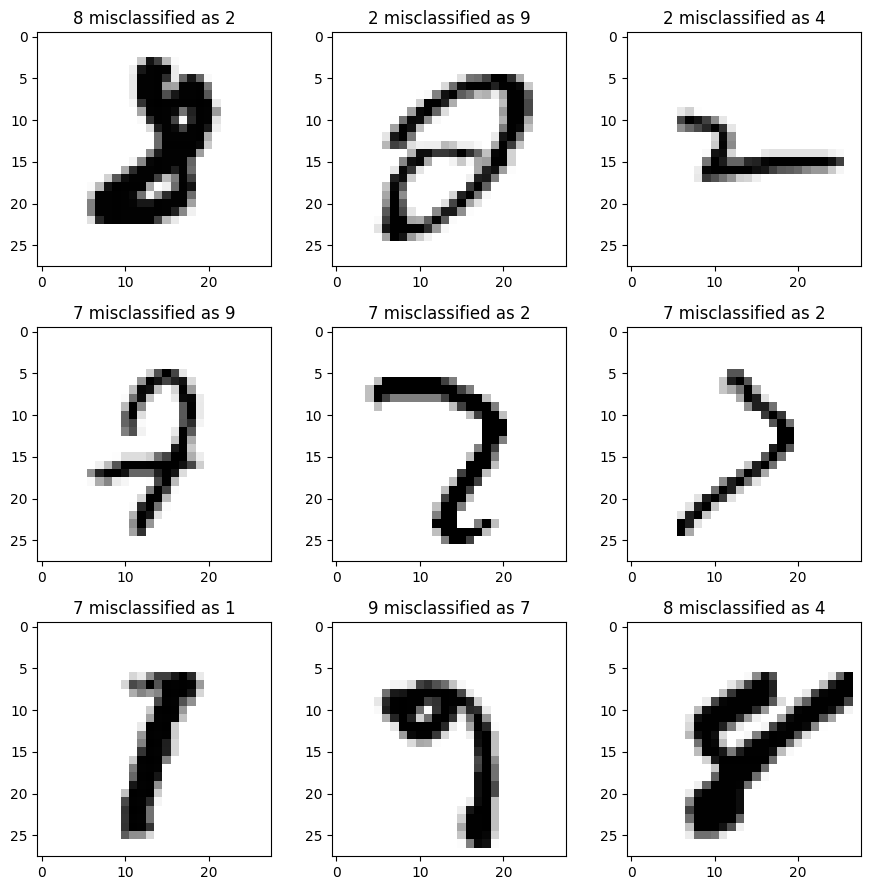

In [18]:
misclassified = eval_data.get_misclassified_triples_pred_true_input()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
for i, (predClass, trueClass, input) in enumerate(misclassified[:9]):
    axs[i//3][i%3].imshow(reshape_2d_image(input), cmap="binary")
    axs[i//3][i%3].set_title(f"{trueClass} misclassified as {predClass}")
plt.tight_layout()

While some of these examples are indeed ambiguous, there still is room for improvement.